In [3]:
# Preparations
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
import seaborn as sns
from IPython.display import Latex
import warnings
from PrettyTable import PrettyTable
from functools import partial
from PrettyFigure import PrettyFigure
warnings.filterwarnings("ignore", module="matplotlib")
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['savefig.dpi'] = 75

# plt.rcParams['figure.autolayout'] = False
# plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.unicode'] = True
plt.rcParams['font.family'] = "STIX"
plt.rcParams['text.latex.preamble'] = "\\usepackage{subdepth}, \\usepackage{type1cm}"

results = {}

sns.set(color_codes=True)

def average(data):
    return 1 / len(data) * sum(data)

def error(data, average_of_data):
    s = sum([(x - average_of_data)**2 for x in data])
    return math.sqrt(s / (len(data) * (len(data) - 1)))

def std_deviation(error_of_average, length_of_dataset):
    return error_of_average * math.sqrt(length_of_dataset)

def average_with_weights(data, weights):
    d = data
    w = weights
    return (d * w**-2).sum() / (w**-2).sum()

def error_with_weights(weights):
    w = weights
    return 1 / math.sqrt((w**-2).sum())

def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    return (d * w**-2).sum() / (w**-2).sum()

def werr(group, weight_name):
    return 1 / math.sqrt((group[weight_name]**-2).sum())

In [4]:
# Constants
x0 = 1.0219 # [m]
e0 = 6e-2 # [m]

# Theoretische Grundlagen

In diesm Versuch wird ein horizontal gelagertes Federpendel unter harmonischer Anregung untersucht.
Durch den Wirbelstrombremseffekt wirkt eine geschwindigkeitsproportionale Reibkraft

\begin{equation}
F_{reib} = -\beta\cdot v
\label{eq:Freib}
\end{equation}

bremsend auf das Pendel. Wobei $\beta$ durch die Anzahl Magneten auf dem Pendel konstant gegeben ist.

Die Anregung kann mit

\begin{equation}
F_{anr}(t) = \hat{F}_e\cdot cos(\Omega t)
\label{eq:Fanr}
\end{equation}

dargestellt werden, wobei

\begin{equation}
\hat{F}_e = \hat{y}_e \cdot k_1
\label{eq:Fe}
\end{equation}

gilt.

## Gedämpfte Schwingung

Für ein freies geschwindigkeitsproportional gedämpftes Pendel gilt

\begin{equation}
y(t) = \hat{y}\cdot e^{-\Gamma t}cos(\omega t - \delta)
\label{eq:pendel}
\end{equation}

mit

<center>
$\Gamma=\frac{\beta}{2m}$  
$\omega=\sqrt{\omega^2_0-\Gamma^2}$  
$\omega^2_0 = \frac{K_{tot}}{m}$
$\Gamma$: Abklingkonstante  
$\omega$: Kreisfrequenz des gedaempften Pendels  
$\omega_0$: Kreisfrequenz des ungedaempften Pendels
</center>

## Erzwungene Schwingung

Die erzwungene Schwingung hat die Form

\begin{equation}
\hat{y}(\gamma) = \frac{k_1\cdot\hat{y}_e}{m\cdot\omega^2_0}\cdot\frac{1}{\sqrt{(1-\gamma^2)^2+4\gamma^2\alpha^2}}
\label{eq:pendelerzwungen}
\end{equation}

mit

<center>
$\gamma=\frac{\Omega}{\omega_0}=\frac{f_e}{f_0}$  
$\alpha=\frac{\Gamma}{\omega_0}=\frac{\Gamma}{2\pi f_0}$  
$\hat{y}_N = \hat{y}_0\cdot e^{-2\pi\alpha N}$  
$tan\delta=\frac{2\gamma\alpha}{1-\gamma^2}$
</center>

# Versuchsaufbau

# Versuchsdurchführung

Zuerst wurde die Schwingungsdauer des Pendels bestimmt.
Dazu wurde das Pendel um verschiedene Distanzen $x_0$ ausgelenkt und dann losgelassen. Eine Lichtschranke registriert dabei jeden zweiten Nulldurchgang und stoppt dabei die Zeit.
Für jede Auslenkung $x_0$ wurde zweimal gemessen.
Die Triggerschwelle wurde dabei nicht zwischen 1-4 Volt gewählt wie im Versuchsbeschrieb empfohlen sondern nach der Empfehlung von Prof. Minamisawa auf 0.6 V eingestellt.

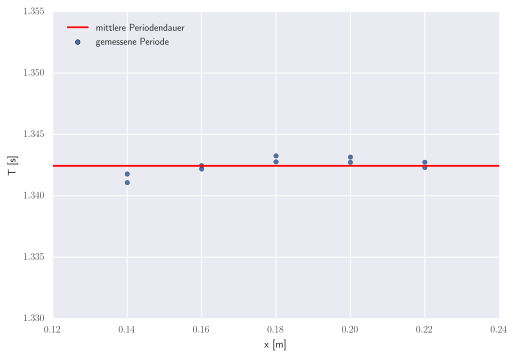

In [54]:
# Read Data
df = pd.read_csv('data/period.csv')
dfp = df

T = df['T'].mean()

ax = df.plot(kind='scatter', x='x', y='T', label='gemessene Periode')
plt.axhline(T, label='mittlere Periodendauer', axes=ax, color='red')
plt.xlabel('x [m]')
plt.ylabel('T [s]')
# plt.ylim([0.005, 0.007])
plt.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.2)

plt.show()

Damit ergibt sich ein $\omega$ von {{'{:.2f}'.format(1/T)}} $s^{-1}$.

Um $\omega$ und $\Gamma$ zu berechnen wird das Pendel ausgelenkt und dann schwingen gelassen. Mit einem Fit an den Amplitudenverlauf können die gewünschten Werte durch den LSQ-Algotithmus ermittelt werden.

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


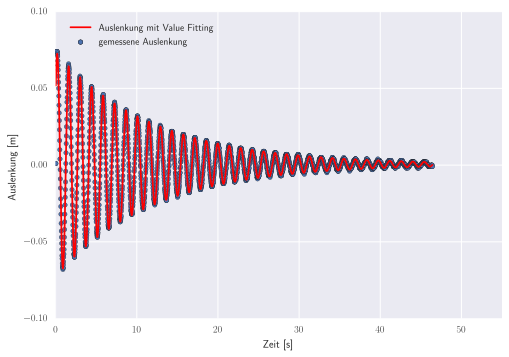

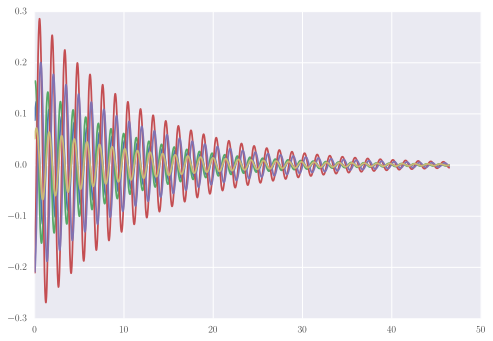

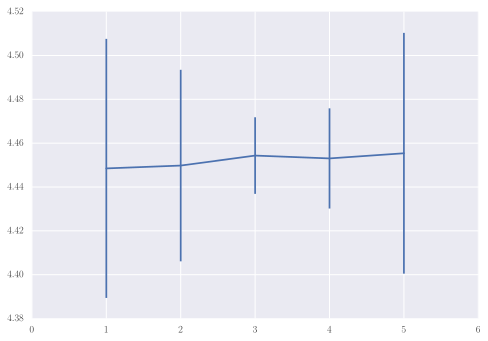

In [97]:
def pendulum(t, y, gamma, w, d, y0):
    return y * np.exp(-gamma * t) * np.cos(w * t - d) + y0

df = pd.DataFrame()
dft = None
sw0 = []

for run in range(1, 6):
    dft = pd.read_csv('data/W6/3.2.{:}.txt'.format(run), sep='\t', skiprows=3, header=None, names=('t', 'y'))
    v, covar = curve_fit(pendulum, dft['t'], dft['y'])
    df = df.append(pd.DataFrame([np.concatenate((v, np.sqrt(np.diag(covar))[1:3]))], columns=('y', 'gamma', 'w', 'd', 'y0', 'sgamma', 'sw')))
    y_fit = [pendulum(t, v[0], v[1], v[2], v[3], v[4]) for t in dft['t']]

ax = dft.plot(kind='scatter', x='t', y='y', label='gemessene Auslenkung')
plt.plot(dft['t'], y_fit, axes=ax, label='Auslenkung mit Value Fitting', color='red')
plt.xlabel('Zeit [s]')
plt.ylabel('Auslenkung [m]')
plt.xlim((0, 55))
plt.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.2)
plt.show()

df['w'] = np.abs(df['w'])
w0 = df['w0'] = np.sqrt(df['w']**2 + df['gamma'])
sw0 = np.sqrt(
               ((df['w']**2 + df['gamma'])**-1/2 + 2*df['w']) * df['sw']
              +((df['gamma']**2 + df['w'])**-1/2 + 2*df['gamma']) * df['sgamma']
             )

for index, row in df.iterrows():
    plt.plot(dft['t'], [pendulum(t, row['y'], row['gamma'], row['w'], row['d'], row['y0']) for t in dft['t']], label='Auslenkung mit Value Fitting')
plt.show()
    
plt.figure()
plt.errorbar(np.arange(1,6), np.array(w0), yerr=np.array(sw0))
plt.xlim(0, 6)
plt.show()

Wenn wir die Formel

<center>
$\omega=\sqrt{\omega^2_0-\Gamma^2}$
</center>

benutzen um $w_0$ zu ermitteln erhalten wir einen Mittelwert von {{'{:.2f}'.format(w0.mean())}} ± {{'{:.2f}'.format(sw0.mean())}} $s^{-1}$

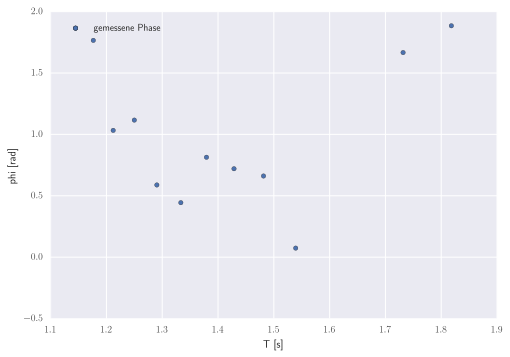

In [6]:
# Read Data
df = pd.read_csv('data/resonance.csv')
dfr = df

# slope, intercept, r, p, sem = stats.linregress(df['x'], df['T'])

ax = df.plot(kind='scatter', x='T', y='phi', label='gemessene Phase')
# plt.plot(df['x'], df['x'] * slope + intercept, label='linearer Fit der Periode', axes=ax)
plt.xlabel('T [s]')
plt.ylabel('phi [rad]')
# plt.ylim([0.005, 0.007])
plt.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.2)

plt.show()

In [15]:
# Messwerte

data = PrettyTable(
    list(zip(dfp['x'], dfp['T'])),
    caption='Messwerte der Periode bei verschiedenen Anfangsauslenkungen.',
    entries_per_column=len(dfp['x'] / 2),
    extra_header=['x [m]', 'T [s]']
)
data.show()

data = PrettyTable(
    list(zip(dfr['T'], dfr['phi'])),
    caption='Messwerte der Phase bei verschiedenen Erregerfrequenzen.',
    entries_per_column=len(dfr['T'] / 2),
    extra_header=['T [m]', 'phi [rad]']
)
data.show()

x [m],T [s]
0.14,1.3417700000000001
0.14,1.34107
0.16,1.34218
0.16,1.34246
0.18,1.34276
0.18,1.34325
0.2,1.3427200000000001
0.2,1.34315
0.22,1.3423
0.22,1.34273


T [m],phi [rad]
1.1764700000000001,1.7658
1.2121,1.0326
1.24999,1.1164
1.29033,0.588
1.33331,0.4438
1.3792799999999998,0.8137
1.42859,0.72022
1.48149,0.661
1.53915,0.0736
1.7316200000000002,1.6666
